In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset, concatenate_datasets

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import numpy as np

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

import evaluate 


In [2]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {label: i for i, label in enumerate(set(df['train']['labels']))}
id2label = {i: label for i, label in enumerate(set(df['train']['labels']))}

In [3]:
id2label

{0: 'secondary_progressive_multiple_sclerosis',
 1: 'primary_progressive_multiple_sclerosis',
 2: 'relapsing_remitting_multiple_sclerosis'}

In [4]:
# # Subsample stratisfied by label
# df['train'] = concatenate_datasets([df['train'].filter(lambda example: example['labels'] == id2label[0]), 
#                                     df['train'].filter(lambda example: example['labels'] == id2label[1]),
#                                     df['train'].filter(lambda example: example['labels'] == id2label[2]).select(range(0,40))])

In [5]:
# # Run this cell if you want to download and fine-tune the model
# from huggingface_hub import notebook_login

# # Login to Hugging Face Hub as model is gated
# notebook_login()

# # Checkpoint
# checkpoint = "GerMedBERT/medbert-512"

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# # Save tokenizer
# tokenizer.save_pretrained(paths.MODEL_PATH/'medbert')

# # Load model for embedding
# model = AutoModel.from_pretrained(checkpoint)

# # Save model
# model.save_pretrained(paths.MODEL_PATH/'medbert')

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /mnt/c/Users/marc_/OneDrive/ETH/MSC_Thesis/inf-extr/resources/models/medbert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt')

    return data

# Tokenize dataset
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [8]:
id2label

{0: 'secondary_progressive_multiple_sclerosis',
 1: 'primary_progressive_multiple_sclerosis',
 2: 'relapsing_remitting_multiple_sclerosis'}

In [9]:
# Training arguments
EPOCHS = 10
BATCH_SIZE = 4
TRAIN_STEPS = EPOCHS * len(dataset['train']) // BATCH_SIZE

# Collator
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

# Dataloader
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Accelerator
accelerator = Accelerator(mixed_precision='fp16')

# Optimizer and scheduler
optim = AdamW(model.parameters(), lr=1e-5)
lr_scheduler = get_scheduler(
    "linear",
    optim,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

f1_metric = evaluate.load("f1")

# Class weights
class_weights = [1/np.sqrt(1+len(dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(dataset['train']['labels'])]
class_weights = torch.tensor(class_weights, dtype=torch.float)

loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

# Prepare with accelerator
model, optim, train_loader, val_loader, test_loader, loss_fun = accelerator.prepare(
    model, optim, train_loader, val_loader, test_loader, loss_fun
)

In [ ]:
# Training
torch.manual_seed(42)
progress_bar = tqdm.tqdm(range(TRAIN_STEPS))

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        outputs = model(**batch)
        loss = loss_fun(outputs.logits, batch['labels'])
        accelerator.backward(loss)
        optim.step()
        lr_scheduler.step()
        progress_bar.update(1)

    model.eval()
    with torch.no_grad():
        f1 = f1_metric
        val_loss = 0
        acc = 0
        for batch in val_loader:
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            val_loss += loss_fun(outputs.logits, batch['labels'])
            acc += (predictions == batch['labels']).sum().item()
            f1.add_batch(predictions=predictions, references=batch['labels'])
        f1 = f1.compute(average='weighted')

    if epoch == 0:
            min_val_loss = val_loss
    elif epoch >= 5 & (val_loss < min_val_loss):
        min_val_loss = val_loss
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert')

    print(f"Epoch {epoch+1}: F1 score: {f1['f1']} Loss: {val_loss/len(val_loader)} Accuracy: {acc/len(dataset['validation'])}")

 10%|█         | 15/147 [00:05<00:39,  3.31it/s]

Epoch 1: F1 score: 0.8166666666666667 Loss: 0.7529802322387695 Accuracy: 0.875


 20%|██        | 30/147 [00:10<00:35,  3.31it/s]

Epoch 2: F1 score: 0.8166666666666667 Loss: 0.6836453080177307 Accuracy: 0.875


 31%|███       | 45/147 [00:16<00:31,  3.19it/s]

Epoch 3: F1 score: 0.8166666666666667 Loss: 0.7238245010375977 Accuracy: 0.875


 41%|████      | 60/147 [00:22<00:27,  3.21it/s]

Epoch 4: F1 score: 0.8166666666666667 Loss: 0.7290360927581787 Accuracy: 0.875


 51%|█████     | 75/147 [00:28<00:22,  3.18it/s]

Epoch 5: F1 score: 0.8166666666666667 Loss: 0.6729236245155334 Accuracy: 0.875


 61%|██████    | 90/147 [00:34<00:17,  3.22it/s]

Epoch 6: F1 score: 0.8166666666666667 Loss: 0.7108385562896729 Accuracy: 0.875


 71%|███████▏  | 105/147 [00:41<00:13,  3.21it/s]

Epoch 7: F1 score: 0.8166666666666667 Loss: 0.6885760426521301 Accuracy: 0.875


 82%|████████▏ | 120/147 [00:47<00:08,  3.16it/s]

Epoch 8: F1 score: 0.8166666666666667 Loss: 0.6394100785255432 Accuracy: 0.875


 92%|█████████▏| 135/147 [00:53<00:03,  3.22it/s]

Epoch 9: F1 score: 0.8166666666666667 Loss: 0.6331738829612732 Accuracy: 0.875


150it [00:59,  3.23it/s]                         

Epoch 10: F1 score: 0.8166666666666667 Loss: 0.6316925287246704 Accuracy: 0.875


In [ ]:
torch.cuda.empty_cache()

# Predictions
predictions = []
labels = []
f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

f1_score = f1_test.compute(average='weighted')
print("F1", f1_score)

100%|██████████| 10/10 [00:00<00:00, 10.25it/s]

F1 {'f1': 0.8166666666666667}


/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.8166666666666667
Precision: 0.765625
Recall: 0.875


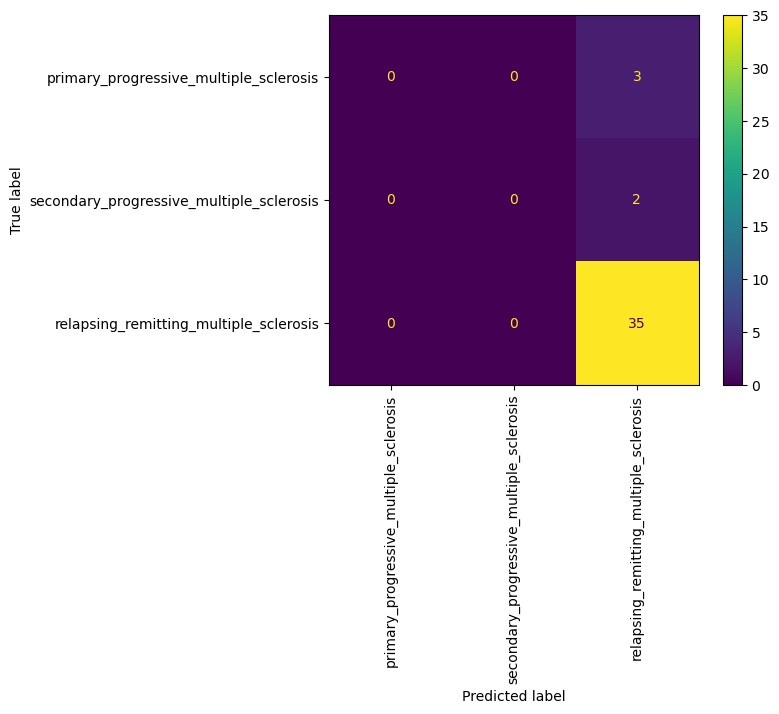

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='weighted')}")
print(f"Precision: {precision_score(labels, predictions, average='weighted')}")
print(f"Recall: {recall_score(labels, predictions, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

In [ ]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
df_test[df_test['labels']==id2label[1]]['text']

18    Schubförmige, unvollständig remittierende Mult...
39    Multiple Sklerose mit sekundär progredientem V...
Name: text, dtype: object

In [ ]:
dataset['train'][:10]

{'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'input_ids': [[2,
   10453,
   9401,
   9025,
   12486,
   16,
   14974,
   5174,
   18,
   5624,
   16,
   8500,
   5267,
   19,
   5545,
   120,
   120,
   8500,
   7896,
   5261,
   19,
   5697,
   30,
   26,
   18,
   20,
   120,
   4855,
   30,
   120,
   120,
   9078,
   11088,
   4683,
   28952,
   4764,
   11251,
   20559,
   16,
   5232,
   4894,
   4718,
   17,
   8950,
   5313,
   4864,
   24105,
   3528,
   6316,
   15874,
   4683,
   18077,
   4715,
   13628,
   5880,
   20456,
   4670,
   16,
   6408,
   4687,
   17,
   9183,
   16,
   16875,
   16818,
   7684,
   5502,
   4774,
   4724,
   4988,
   120,
   120,
   6750,
   19,
   9884,
   4667,
   13533,
   5174,
   18,
   5979,
   5624,
   16,
   4744,
   5150,
   6160,
   16569,
   8973,
   120,
   9078,
   9733,
   4683,
   24274,
   4798,
   12312,
   8091,
   5659,
   4744,
   5261,
   19,
   5565,
   120,
   120,
   6696,
   30,
   120,
   120,
   7424,
   120,
   120,
  